# Forward and Inverse problem with surrogate models via Kratos Multiphysics

This is document that should serve as both a demonstration and a tutorial of the current status of AI-related utilities within Kratos.
It should raise awareness of current problems and be updated as they are progressively solved.

We are taking a small structural mechanics problem as our use-case. Specifically, we model a 2D cantilever attached on one end and with a vertical point load applied on the other. The force is constant, but the Young modulus of the cantilever material is variable. 


![CANTILEVER](cantilever_mesh.png)

We define two AI-related tasks for it:

1. Generation of a surrogate model in the form of a neural network. Particularly, it will make use of both a data-based loss and a PINN-like loss: based on the discrete residual that we obtain form Kratos itself (be aware that when we refer to the residual, we mean specifically the RHS of the finite element's assembly)
2. Inverse problem (estimating the Young modulus from a given solution) via data-bsaed Gausian Process.

The first step in any ML-related application is the gathering of data. This will be useful for both approaches, so we tackle how to do data gathering easily within Kratos in the next section.

## Dataset Generation

We need to gather data in order to train our models. For the first approach, even if we are doing physics-based training, we would still like to have part of the loss being based on data, if the user wants so.

The ROM application within Kratos implements a data-collection system based on two components:
- ROM Manager: A simulations orchestrator that allows the user to automatically run simulations while varying some specific parameters. As it is part of the ROM application, it also orchestrates the training and running of intrusive projection-based ROM within Kratos, but we are not interested in these features in the current example.
- ROM Database: An SQL-based database in order to store the results from Kratos simulations. The data is saved locally in individual .npy files whose names are hashes depending on the corresponding parameter values.

Let's see for our particular problem. We are given:
- The Kratos-compatible mesh for the structural mechanics simulation (MDPA file).
- The Project Parameters file to be used as the base for our simulations.
- The Material Parameters file to be used as the base for our simulaitions.

We decide a parameter for our models to estimate, and a parametric space to work in. In our case we vary the Young modulus of the material in a range from 1.0e11 to 4.0e11.
For each of the explored Young modulus we want to collect the solution, in terms of nodal displacements. We would like to store these as a vector following Kratos' own ordering of degrees of freedom. In this case it will be [x_1, y_1, x_2, y_2, ..., x_N, y_N] where N is the number of nodes in our geometry. Take into account that our case is static, so runs for just one time step. For simulations that run for multiple time steps, by default all of their solutions will be saved, obtaining a matrix instead of a vector for each simulation.
After generating a number M of random samples and storing their results, we will want to aggregate them into a numpy matrix that we can then save locally in order to use later.

Let's go over the code needed to operate the ROM Manager and Database.
First we import all needed libraries:

In [ ]:
import os

import numpy as np
import importlib

import KratosMultiphysics
import KratosMultiphysics.StructuralMechanicsApplication
from KratosMultiphysics.RomApplication.rom_manager import RomManager
import json


import torch
import torch.nn as nn

from scipy.stats import qmc

 |  /           |                  
 ' /   __| _` | __|  _ \   __|    
 . \  |   (   | |   (   |\__ \  
_|\_\_|  \__,_|\__|\___/ ____/
           Multi-Physics 10.2."1"-master-337fbf72f0-Release-x86_64
           Compiled for GNU/Linux and Python3.12 with GCC-11.4
Compiled with threading support. Threading support with OpenMP.
Maximum number of threads: 16.
Importing    KratosStructuralMechanicsApplication 
    KRATOS   ___|  |                   |                   |
           \___ \  __|  __| |   |  __| __| |   |  __| _` | |
                 | |   |    |   | (    |   |   | |   (   | |
           _____/ \__|_|   \__,_|\___|\__|\__,_|_|  \__,_|_| MECHANICS
Initializing KratosStructuralMechanicsApplication...
Importing    KratosConstitutiveLawsApplication 
Initializing KratosConstitutiveLawsApplication...
Importing    LinearSolversApplication 
    Kratos  _     _                       ____        _
           | |   (_)_ __   ___  __ _ _ __/ ___|  ___ | |_   _____ _ __ ___
           | |

In order to configure and call the ROM Manager, we need to define a few functions and variables first.

Variables:
- mu_list: this is how we call the list of parameters to run. It is a list of lists, each of the interior lists (mu) being the complete set of parameters for one simulation. Imagine we would like to modify a point load in the x direction, another in the y direction and the Young modulus, for M simulations we would have: [[Fx_1,Fy_1,E_1],[Fx_2,Fy_2,E_2],...,[Fx_N,Fy_N,E_N]]. In our case, we only modify the Young modulus, so it would be [[E_1],[E_2],...,[E_N]].
- rom_manager_parameters: these are the Kratos parameters that will be used to configure the ROM Application. In our case, we only want to generate data, and to do that we can leave almost everything in default, just specifiying:
    - rom_stages_to_train: ["ROM"]. Because the way to save the snapshots is to train a POD-based intrusive ROM with those snapshots. This should be changed (more details later)
    - ROM / model_part_name: "Structure". This is only in our case. Generally, it should be the name for the modelpart written in the MDPA file.                 
    - ROM / nodal_unknowns: ["DISPLACEMENT_X","DISPLACEMENT_Y"]. This is only in our case. Generally, it should be the names of the DoFs to include for each node in the solution snapshot. Something to be careful about is the fact that the ordering in the final snapshot is not necessarily the order specified here, but the alphabetic order instead.
- project_parameters_name: just the string corresponding to the path pointing to the Project Parameters JSON file

Functions:
- CustomizeSimulation(): provides a Kratos Analysis Stage to apply on top of the simulation's own, in case the user wants to customize it.
- UpdateProjectParameters(): specifies which entries form the Project Parameters to modify, given a sub-list of mu.
- UpdateMaterialParametersFile(): specifies which entries from the Material Parameters to modify, given a sub-list of mu. Be aware that it works by making the changes in the actual Material Parameters json file itself.

Things to improve:
- The parameters list (mu) should have the possibility to be given as a Numpy array. Right now it is incompatible.
- Make the UpdateMaterialParametersFile function change the parameters internally, without modifying the original json file.
- Explicitly determine which is the order of the nodal unknowns as presented in the solution snapshots. They should either be determined by the user, or be determined by the internal DoFs list within Kratos (tricky because they may change from one simulation to another or even within a single simulation.)

In [2]:
def CustomizeSimulation(cls, global_model, parameters, mu=None):

    # In our case, we do not need any customization within the analysis stage.
    # We still leave the skeleton of the analysis stage for illustration purposes

    class CustomSimulation(cls):

        def __init__(self, model,project_parameters, custom_param = None):
            super().__init__(model,project_parameters)
            """
            Customize as needed
            """
            # We get the model part for future use
            self.modelpart = self._GetSolver().GetComputingModelPart()
            self.fixity_config_list = None

        def Initialize(self):
            super().Initialize()
            """
            Customize as needed
            """
            # We define the list of Kratos variables that we are including in the solution snapshots
            # We get the list of strings that we indicate later on in the ROM configuration, and find the corresponding
            # variables for them.
            nodal_unknowns = self.project_parameters["output_processes"]["rom_output"][0]["Parameters"]["nodal_unknowns"].GetStringArray()
            nodal_unknowns.sort()
            self.snapshot_variables_list = []
            for var_name in nodal_unknowns:
                self.snapshot_variables_list.append(KratosMultiphysics.KratosGlobals.GetVariable(var_name))

        def FinalizeSolutionStep(self):
            """
            Customize as needed
            """

            # Check which nodes are fixed by Dirichlet conditions (fixity configuration).
            # Go over nodes and check if their degrees of freedom are fixed then build a list with their indexes.
            fixity_config_aux = []
            dof_id=0
            for node in self.modelpart.Nodes:
                for var in self.snapshot_variables_list:
                    dof = node.GetDof(var)
                    if dof.IsFixed():
                        fixity_config_aux.append(dof_id)
                    dof_id+=1
            if self.fixity_config_list is None: 
                self.fixity_config_list = fixity_config_aux
            else:
                # Check that the fixity configuration is always the same. Otherwise raise an error
                if not self.fixity_config_list == fixity_config_aux:
                    KratosMultiphysics.Logger.PrintInfo("Different fixities found within the same case")
                    raise NotImplementedError

            super().FinalizeSolutionStep()

        def Finalize(self):
            super().Finalize()
            fixity_config_filename = "FixityConfig_list.npy"
            if os.path.isfile(fixity_config_filename):
                current_fixity_config_array = np.load(fixity_config_filename)
                if not np.all(self.fixity_config_list == current_fixity_config_array):
                    KratosMultiphysics.Logger.PrintInfo("Different fixities found within different simulations")
                    raise NotImplementedError
            else:
                np.save(fixity_config_filename, self.fixity_config_list)


    return CustomSimulation(global_model, parameters)

def UpdateProjectParameters(parameters, mu=None):
    """
    Customize ProjectParameters here for imposing different parameters to the simulations as needed.

    We do not need it in our case but, for illustration purposes, let's say we would like to modify the magnitude of the point load in each sample.
    Then, we would write this (at least for our specific Project Parameters file):
    parameters["processes"]["loads_process_list"][0]["Parameters"]["modulus"].SetDouble(mu[0])
    """
    return parameters

def UpdateMaterialParametersFile(material_parametrs_file_name, mu):
    """
    Customize MaterialParameters here for imposing different parameters to material as needed.

    We read the MaterialParameters JSON file, modify its data and save it again.
    In our case we change the Young modulus to whatever is in the mu list.
    """
    with open(material_parametrs_file_name, mode="r+") as f:
        data = json.load(f)
        data["properties"][0]["Material"]["Variables"]["YOUNG_MODULUS"] = mu[0]
    with open(material_parametrs_file_name, mode="w") as f:
        json.dump(data,f)

rom_manager_parameters = KratosMultiphysics.Parameters("""{
            "rom_stages_to_train" : ["ROM"],                            // List of stages to train. Essentially "ROM", "HROM" or both of them.
            "ROM":{
                "model_part_name": "Structure",                         // This changes depending on the simulation: Structure, FluidModelPart, ThermalPart #TODO: Idenfity it automatically
                "nodal_unknowns": ["DISPLACEMENT_X","DISPLACEMENT_Y"]  // Main unknowns. Snapshots are taken from these
            }
        }""")

project_parameters_name = "ProjectParameters.json"

With these, we can already instantiate the RomManager

In [3]:
rom_manager = RomManager(project_parameters_name,rom_manager_parameters,CustomizeSimulation,UpdateProjectParameters,UpdateMaterialParametersFile)

Table FOM created successfully.
Table ROM created successfully.
Table HROM created successfully.
Table NonconvergedFOM created successfully.
Table NonconvergedROM created successfully.
Table NonconvergedHROM created successfully.
Table RightBasis created successfully.
Table SingularValues_Solution created successfully.
Table LeftBasis created successfully.
Table PetrovGalerkinSnapshots created successfully.
Table ResidualsProjected created successfully.
Table SingularValues_Residuals created successfully.
Table HROM_Elements created successfully.
Table HROM_Weights created successfully.
Table Neural_Network created successfully.
Table QoI_FOM created successfully.
Table QoI_ROM created successfully.
Table QoI_HROM created successfully.


Now we need to call the training routine within the RomManager on the list of parameters we want to simulate (mu_list).

In order to build mu_list, we will use a 1D Halton sequence. We will actually generate three differerent parameters list (one for training, one for validation and one for testing), so we will implement the mu_list generation routine as a function. Then we call it three times. We get 100 samples for the training, 20 for the validation and another 20 for the test.

Of course, the user may do this in any other way they see fit.

In [4]:
young_modulus_upper_limit=100000000000.0
young_modulus_lower_limit=400000000000.0

def get_multiple_params(n_samples, seed):
    # We call the method specifying the number of samples to generate and the seed to use.
    sampler_test = qmc.Halton(d=1, seed=seed)
    mu_list=sampler_test.random(n=n_samples)
    mu_list = qmc.scale(mu_list, [young_modulus_upper_limit], [young_modulus_lower_limit]) # Here we specify the lower and upper bounds of the parameter space.
    return mu_list.tolist() # Make sure that it is a list and not a numpy array

mu_train = get_multiple_params(100, 123) # random train parameters
mu_validation = get_multiple_params(20, 632) #random validation parameters
mu_test = get_multiple_params(20, 383) #random test parameters

We generate the samples for the training dataset by calling the Fit method of the RomManager. This will first go over the whole mu_list, simulating each sample and saving it in the RomDatabase. Then, even if we do not need it, it will train a basis for projection-based ROM and run again the whole mu_list using ROM instead.
There is a method, RunFOM, designed to just run the full order model itself on the data, without any posterior training. However, it does not save the solutions in the database, therefore it is not useful to us. This should be changed.

There is no way, currently, of directly retrieving the expected size of the solution snapshots before running some simulation. This should be solved, but for now we will work around it by first performing a simulation (with any parameter), retrieving its snapshot and checking its shape manually.

Finally, there is also no way to directly obtain the aggregated matrix of snapshots for several parameter values. There is the method get_snapshots_matrix_from_database form the RomDatabase, which does it but it reorders the snapshots within the matrix, making it non-suitable for this case (it does for snaphsot de-duplication within ROM, where we do not care about snapshot order). 

In [5]:
# Beware that this method will also train a ROM basis, which we don't care about.
rom_manager.Fit(mu_train=mu_train)

# There should be a standalone method to retrieve the size of the snapshot.
# For now, we use get_hashed_file_name_for_table() to get the hash of a simulation (the first one, for example),
# then we use get_single_numpy_from_database() to read the corresponding file and check the resulting array's shape.
snapshot_hash = rom_manager.data_base.get_hashed_file_name_for_table('FOM', mu_train[0])[0]
snapshot_size = rom_manager.data_base.get_single_numpy_from_database(snapshot_hash).shape[0]

# get_snapshots_matrix_from_database() will reorder the snapshots (and deduplicate them), so they will not necessarily
# be in the same order as mu_list. Therefore, instead, we get each sample individually in the order of mu_list and add
# them manually to the final Numpy array
def build_and_save_snapshots_matrix(mu_list, mu_file_name, snapshots_file_name):
    snapshots_matrix = np.empty((0,snapshot_size))
    for i in range(len(mu_list)):
        snapshot_hash = rom_manager.data_base.get_hashed_file_name_for_table('FOM', mu_list[i])[0]
        snapshot = rom_manager.data_base.get_single_numpy_from_database(snapshot_hash).flatten()
        snapshots_matrix=np.vstack([snapshots_matrix, snapshot.copy()])
    np.save(mu_file_name, np.array(mu_list))
    np.save(snapshots_file_name, np.array(snapshots_matrix))

build_and_save_snapshots_matrix(mu_train, "Mu_train.npy", "SnapshotsMatrix_train.npy")

rom_manager.Fit(mu_train=mu_validation)
build_and_save_snapshots_matrix(mu_validation, "Mu_validation.npy", "SnapshotsMatrix_validation.npy")

rom_manager.Fit(mu_train=mu_test)
build_and_save_snapshots_matrix(mu_test, "Mu_test.npy", "SnapshotsMatrix_test.npy")

[WARNING] DEPRECATION-Warning; MechanicalSolver: Using "line_search", please move it to "solving_strategy_settings" as "type" 
::[MechanicalSolver]:: : Construction finished 
::[StaticMechanicalSolver]:: : Construction finished 
::[MechanicalSolver]:: : Variables ADDED 
::[PythonSolver]::: Reading model part. 
SingleImportModelPart: Reading model part from file: "/home/nsibuet/Documents/KRatosHackaton/beam_si".mdpa
ModelPartIO:   [Reading Nodes    : 38 nodes read]
ModelPartIO:   [Reading Elements : 47 elements read] [Type: UpdatedLagrangianElement2D3N]
ModelPartIO:   [Reading Conditions : 1 conditions read] [Type: PointLoadCondition2D1N]
ModelPartIO:   [Total Lines Read : 209]
SingleImportModelPart: Finished reading model part from mdpa file.
ModelPart: -Structure- model part
    Buffer Size : 1
    Number of tables : 0
    Number of sub model parts : 3
    Current solution step index : 0
    DOMAIN_SIZE : 2
    OSS_SWITCH : 0
    IS_RESTARTED : 0

    Number of Geometries  : 0
    Mes

## Discrete PINN-like surrogate model

Now that we have the data, we may use it to train surrogate models for forward problem solving. That is, estimating an approximation to the FEM solution given the simulation parameter (Young modulus) via a much smaller and efficient approach than FEM itself.

In this first part we implement a Neural-Network-based model that will be trained via both data and the problem's physics. Similar to a PINN, our model will use the residual as part (if not all) of its training loss, only that in this case we consider the residual to be the assembled discrete RHS of the FEM problem, given by the model's elements. We take advantage that Kratos (as any other FEM software) has the functionality to assemble both this RHS and the LHS for the problem, which corresponds to the derivative of the RHS with respect to the trial function coefficients.

Let's see first what the proposed architecture of the Neural Network is, as it will condition how we design the loss aswell.
Neural Network's inputs and outputs:
- Inputs: Young modulus (scalar)
- Outputs: estimation of solution snapshot (vector)

Therefore, $\mathbf{u}=\mathcal{N}(E^*;\boldsymbol{\theta})\approx\mathbf{u^*}$. Where $\mathbf{u^*}\in\mathbb{R}^n$ and $E^*\in\mathbb{R}$ are the ground truth snapshots (from FEM) and corresponding Young modulus, respectively. Then $\mathcal{N}$ is the neural network, with its trainable parameters list $\boldsymbol{\theta}$, and the result $\mathbf{u}$ is the approximation of $\mathbf{u^*}$. To be exact, we only work with the degrees of freedom that are fixed (not bound by Dirichlet conditions), as these should be forced to their exact values. This case has the advantage that the displacement value for fixed DoFs will always be zero, so we can just remove them from the computation altogether. In cases where it could be non-zero, more elaborate masking and unmasking techniques could be needed.

Let's implement the architecture of such a neural network, with three hidden layers (the first one with 10 neurons, the second one with 50, the second one with 100). We use the ELU activation function.

In [6]:
class DiscretePINN(nn.Module):
    def __init__(self, input_size, snapshot_size, fixed_dofs_list):
        super(DiscretePINN, self).__init__()

        # Get number of free DoFs and get mapping from only free DoFs to complete snapshot vector
        non_fixed_dofs_size = snapshot_size - fixed_dofs_list.shape[0]
        full_snapshot_map = np.zeros((non_fixed_dofs_size,snapshot_size))
        i=0
        for j in range(snapshot_size):
            if not j in fixed_dofs_list:
                full_snapshot_map[i,j] = 1
                i+=1
        full_snapshot_map_tensor = torch.FloatTensor(full_snapshot_map).T
        map_layer = nn.Linear(non_fixed_dofs_size, snapshot_size, bias=False)
        with torch.no_grad():  # Temporarily disable gradient tracking
            map_layer.weight.data = full_snapshot_map_tensor
        map_layer.weight.requires_grad_(False)

        self.net = nn.Sequential(
            nn.Linear(input_size, 10), # Input: E
            nn.ELU(),
            nn.Linear(10, 50),
            nn.ELU(),
            nn.Linear(50, 100),
            nn.ELU(),
            nn.Linear(100, non_fixed_dofs_size), # Output: free DoFs of u (vector)
            map_layer # Output: complete u (vector)
        )

    def forward(self, x):
        return self.net(x)
    
# Input size is one (E is a scalar)
nn_input_size = 1

# Get list of IDs for fixed DoFs
fixed_dofs_list = np.load("FixityConfig_list.npy")
    
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the NN model
model = DiscretePINN(nn_input_size, snapshot_size, fixed_dofs_list).to(device)

For the loss, we use a mix of data and physics-based. The typical approach for a data-based loss would be to take the Mean Squared Error (MSE) of vector $\mathbf{u}$ against $\mathbf{u^*}$:

$\mathcal{L}_d=\frac{1}{2}\frac{1}{m_dn}\sum^{m_d}_{i=1}\left\Vert\mathbf{u_i}-\mathbf{u^*_i}\right\Vert^2$

On the other hand, for a physics-based loss, we look at the one from PINNS, which is essentially a MSE on the value of the residual. In traditional PINNs, that residual is a scalar, derived from the strong form of the PDE. In our case we are using the RHS vector instead, which derives from the PDE's weak form, so we use its norm as the quantity to minimize:

$\mathcal{L}_R=\frac{1}{2}\frac{1}{m_Rn}\sum^{m_R}_{i=1}\left\Vert R(\mathbf{u_i};E_i^*)\right\Vert^2$

Here it is important to correctly set the given $E_i^*$ value within the RHS assembly, as otherwise we would be training the neural network for a different case.

<b>IMPORTANT</b>: Take into account that, in order for the minimization of the RHS norm to be meaningful, the components of the RHS that are affected by Dirichlet conditions must be removed. Otherwise the norm will not necessarily fall to 0 as the approximated snapshots approaches the ground truth. Another option would be to use a varaition of the parameter-agnostic loss described in [https://doi.org/10.3390/axioms14050385], which would not have such requirement but would still depend on ground-truth data even for the physics-driven loss. Such a loss would be: $\mathcal{L}_{R,\text{alt.}}=\frac{1}{2}\frac{1}{m_Rn}\sum^{m_R}_{i=1}\left\Vert R(\mathbf{u_i};E_i^*)-R(\mathbf{u_i^*};E_i^*)\right\Vert^2$.

The difficult part regarding this loss in the training process is that Pytorch cannot perform automatic differentiation to obtain the gradients of $\mathcal{L}_R$ with respect to $\boldsymbol{\theta}$ (the RHS computation is done within Kratos and therefore it is obscure to Pytorch). We check what the gradient would look like when expanding with the chain rule:

$\frac{\partial \mathcal{L}_R}{\partial \boldsymbol{\theta}}=\frac{1}{m_Rn}\sum^{m_R}_{i=1}R(\mathbf{u_i};E_i^*)^T\frac{\partial R(\mathbf{u_i};E_i^*)}{\partial \mathbf{u_i}}\frac{\partial \mathbf{u_i}}{\partial \boldsymbol{\theta}}$

So, to implement this gradient we need both $R(\mathbf{u_i};E_i^*)$ and $\frac{\partial R(\mathbf{u_i};E_i^*)}{\partial \mathbf{u_i}}$, which correspond to the RHS and LHS from Kratos, respectively (without components from Dirichlet conditions) and then integrate it into the Pytorch-driven computations. In order to greatly simplify the implementation, we compute two vectors within Kratos:
- $\mathbf{e}_{R,i} = R(\mathbf{u_i};E_i^*)$
- $\mathbf{v}_{R,i} = R(\mathbf{u_i};E_i^*)^T\frac{\partial R(\mathbf{u_i};E_i^*)}{\partial \mathbf{u_i}}$

And we treat these as constants in order to compute a pseudo-loss:
$\mathcal{L'}_R=\frac{1}{m_Rn}\sum^{m_R}_{i=1}\mathbf{v}_R\mathbf{u_i}$ to which we can actually apply auto-differentiation in order to obtain the same gradient as we would with $\mathcal{L}_R$:
$\frac{\partial \mathcal{L'}_R}{\partial \boldsymbol{\theta}}=\frac{\partial}{\partial \boldsymbol{\theta}}\frac{1}{m_Rn}\sum^{m_R}_{i=1}\mathbf{v}_R\mathbf{u_i}=\frac{1}{m_Rn}\sum^{m_R}_{i=1}\mathbf{v}_R\frac{\partial \mathbf{u_i}}{\partial \boldsymbol{\theta}}=\frac{\partial \mathcal{L}_R}{\partial \boldsymbol{\theta}}$

The joint data-and-physics loss would be given by:
$\mathcal{L}_{\text{total}}=\frac{1}{2n}\left(\omega_d\frac{1}{m_d}\sum^{m_d}_{i=1}\left\Vert\mathbf{u_i}-\mathbf{u^*_i}\right\Vert^2+\omega_R\frac{1}{m_R}\sum^{m_R}_{i=1}\left\Vert R(\mathbf{u_i};E_i^*)\right\Vert^2\right)$

Which will be implemented as:
$\mathcal{L}_{\text{total}}=\frac{1}{2n}\left(\omega_d\frac{1}{m_d}\sum^{m_d}_{i=1}\left\Vert\mathbf{u_i}-\mathbf{u^*_i}\right\Vert^2+\omega_R\frac{1}{m_R}\sum^{m_R}_{i=1}\left\Vert \mathbf{e}_{R,i}\right\Vert^2\right)$
$\frac{\partial \mathcal{L}_{\text{total}}}{\partial \boldsymbol{\theta}}=\frac{\partial}{\partial \boldsymbol{\theta}}\frac{1}{2n}\left(\omega_d\frac{1}{m_d}\sum^{m_d}_{i=1}\mathbf{e}_d^T\mathbf{u_i}+\omega_R\frac{1}{m_R}\sum^{m_R}_{i=1}\mathbf{v}_{R,i}^T\mathbf{u_i}\right)$

where $\mathbf{e}_d=\mathbf{u_i}-\mathbf{u^*_i}$, treated as a constant from the point of view of Pytorch.

Let's implement the code for this.

First we need to implement the Kratos functionalities to retrieve $e_{R,i}$ and $v_{R,i}$.

Essentially, we will generate and initialize a dummy Kratos simmulation, and then manually configure the given snapshot ($\textbf{u}_i$) and Young modulus ($E_i$). Then, we assemble both RHS and LHS, remove Dirichlet conditions from these and use them to obtain the needed vector quantities.

In [7]:
# Let's implement the class in charge of interfacing Pytorch with Kratos
class StructuralMechanics_NN_Interface():

    def __init__(self, kratos_simulation):

        # We take a Kratos simulation configured with the ProjectParameters, but which we will not run according to the Analysis Stage
        self.fake_simulation = kratos_simulation
        
        # We perform the initialization of the simulation and leave it as if we were about to solve the first time step
        self.fake_simulation.Initialize()
        self.fake_simulation.InitializeSolutionStep()

        # For using later
        self.space = KratosMultiphysics.UblasSparseSpace()
        self.strategy = self.fake_simulation._GetSolver()._GetSolutionStrategy()
        self.buildsol = self.fake_simulation._GetSolver()._GetBuilderAndSolver()
        self.scheme = self.fake_simulation._GetSolver()._GetScheme()
        self.modelpart = self.fake_simulation._GetSolver().GetComputingModelPart()
        self.var_utils = KratosMultiphysics.VariableUtils()

    def configure_simulation_to_sample(self, snapshot, mu):
        # This method modifies the current configuration of the simulation to accomodate it to the current sample.
        
        # First we set both the nodal displacements and the actual node positions according to the given snapshot.
        values = snapshot
        values_full=np.zeros(self.modelpart.NumberOfNodes()*2)
        values_full+=values
        dim = 2
        nodes_array=self.modelpart.Nodes
        x0_vec = self.var_utils.GetInitialPositionsVector(nodes_array,dim)
        self.var_utils.SetSolutionStepValuesVector(nodes_array, KratosMultiphysics.DISPLACEMENT, values_full, 0)
        x_vec=x0_vec+values_full
        self.var_utils.SetCurrentPositionsVector(nodes_array,x_vec)

        # Then we set the Young modulus to the given value. Notice that we do it only for element 1, as the
        # Young modulus parameter is unique and accessed by all elements via pointers.
        self.modelpart.GetElement(1).Properties.SetValue(KratosMultiphysics.YOUNG_MODULUS, mu[0])
    
    def get_e_and_v_vectors(self, y_pred, mu):
        # Get the matrix and vector that accomodate the RHS and LHS, respectively
        A = self.strategy.GetSystemMatrix()
        b = self.strategy.GetSystemVector()
        # Create an empty vector pointer
        foo  = self.space.CreateEmptyVectorPointer()

        e_R_list=[]
        v_R_list=[]

        # Iterate over the given batch
        for i in range(y_pred.shape[0]):
            # Set RHS and LHS to zero just in case
            self.space.SetToZeroMatrix(A)
            self.space.SetToZeroVector(b)

            # Configure the simulation with the given information from the sample
            self.configure_simulation_to_sample(y_pred[i],mu[i])
            
            try:
                # Build RHS and LHS and then remove the components related to Dirichlet conditions
                self.buildsol.Build(self.scheme, self.modelpart, A, b)
                self.buildsol.ApplyDirichletConditions(self.scheme, self.modelpart, A, foo, b)
            except:
                print("Problem assembling for E = ", mu[i])

            e_R=KratosMultiphysics.Vector(b)

            # Create an empty vector for v_R, adjust it to the appropriate size and set it to zero
            v_R = self.space.CreateEmptyVectorPointer()
            self.space.ResizeVector(v_R, self.space.Size(b))
            self.space.SetToZeroVector(v_R)

            # Do matrix vector multiplication and set the result into v_R
            self.space.TransposeMult(A,e_R,v_R)

            # This negative is to compensate the fact that the jacobian of the RHS with respect to
            # the degrees of freedom is actually -1*LHS, and not just LHS.
            v_R=KratosMultiphysics.Vector(-1*v_R)
            
            e_R_list.append(np.expand_dims(np.array(e_R, copy=False),axis=0))
            v_R_list.append(np.expand_dims(np.array(v_R, copy=False),axis=0))

        err_r_batch = np.concatenate(e_R_list, axis = 0)
        v_loss_r_batch = np.concatenate(v_R_list, axis = 0)
        
        return err_r_batch, v_loss_r_batch

# We first load the parameters for the Kratos simulation (from the Project Parameters file)
with open("ProjectParameters.json", 'r') as parameter_file:
    parameters = KratosMultiphysics.Parameters(parameter_file.read())

# We find out, from the project parameters, which analysis stage we should use
analysis_stage_module_name = parameters["analysis_stage"].GetString()
analysis_stage_class_name = analysis_stage_module_name.split('.')[-1]
analysis_stage_class_name = ''.join(x.title() for x in analysis_stage_class_name.split('_'))
analysis_stage_module = importlib.import_module(analysis_stage_module_name)
analysis_stage_class = getattr(analysis_stage_module, analysis_stage_class_name)

# We create a Kratos model and instantiate the Analysis Stage with it and the parameters
global_model = KratosMultiphysics.Model()
simulation = analysis_stage_class(global_model, parameters)

# Finally we instanitate the interface by passing the Kratos simulation
kratos_interface = StructuralMechanics_NN_Interface(simulation)

[WARNING] DEPRECATION-Warning; MechanicalSolver: Using "line_search", please move it to "solving_strategy_settings" as "type" 
::[MechanicalSolver]:: : Construction finished 
::[StaticMechanicalSolver]:: : Construction finished 
::[MechanicalSolver]:: : Variables ADDED 
::[PythonSolver]::: Reading model part. 
SingleImportModelPart: Reading model part from file: "/home/nsibuet/Documents/KRatosHackaton/beam_si".mdpa
ModelPartIO:   [Reading Nodes    : 38 nodes read]
ModelPartIO:   [Reading Elements : 47 elements read] [Type: UpdatedLagrangianElement2D3N]
ModelPartIO:   [Reading Conditions : 1 conditions read] [Type: PointLoadCondition2D1N]
ModelPartIO:   [Total Lines Read : 209]
SingleImportModelPart: Finished reading model part from mdpa file.
ModelPart: -Structure- model part
    Buffer Size : 1
    Number of tables : 0
    Number of sub model parts : 3
    Current solution step index : 0
    DOMAIN_SIZE : 2
    OSS_SWITCH : 0
    IS_RESTARTED : 0

    Number of Geometries  : 0
    Mes

Now that we have a way to obtain residuals and related quantities from Kratos, we can finally implement the loss itself, $\mathcal{L}_{\text{total}}$ .
We implement a function that outputs the loss and its gradietns for a batch, given $\omega_d$, $\omega_R$, a set of Young modulus $\{E_i\}_{i=1}^{m_d}$ , with their corresponding FEM solution snapshots $\{\mathbf{u}_i\}_{i=1}^{m_d}$, and another set of Young modulus for the physics-based part $\{E_i\}_{i=1}^{m_R}$. Notice that the batch set size is typically smaller than the total amount of data we have available ($m_d<n_d$).

In [8]:
def get_loss_and_pseudoloss(model, w_d, w_R, rescaled_mu_list_data, u_list_data, rescaled_mu_list_phys, mu_list_phys):
    # We recieve both omega weights, the parameters and snapshots for the data-based part and the parameters for the physics-based part

    # Process the data-based batch with the neural network to get the snapshot approximations
    u_data = model(rescaled_mu_list_data)
    
    # Use no_grad so no gradients are computed, and compute e_u. It will work as a constant.
    with torch.no_grad():
        e_u = u_data.detach().clone()-u_list_data
    
    # Use e_u to compute the actual data-based loss and the data-based pseudo-loss that will be used to compute the gradients 
    loss_data = torch.mean(torch.mul(e_u,e_u))
    pseudo_loss_data = torch.mean(torch.mul(e_u,u_data))

    # Process the batch for the physics-based part of the loss via the neural network
    u_list_phys = model(rescaled_mu_list_phys)

    # Again using no-grad, compute e_R and v_R. We do so by calling the appropraite method in the kratos-pytorch interface.
    # We must pass both the approximated solution snapshots and the corresponding list of Young modulus to the method.
    if w_R == 0:
        with torch.no_grad():
            loss_phys = torch.FloatTensor([0.0]).to(device)
            pseudo_loss_phys = torch.FloatTensor([0.0]).to(device)
    else:
        with torch.no_grad():
            u_list_phys_numpy = u_list_phys.detach().cpu().numpy()
            mu_list_phys_numpy = mu_list_phys.detach().cpu().numpy()
            e_R, v_R = kratos_interface.get_e_and_v_vectors(u_list_phys_numpy, mu_list_phys_numpy)
            e_R = torch.FloatTensor(e_R).to(device)
            v_R = torch.FloatTensor(v_R).to(device)

        # Use e_R and v_R to compute the actual physics-based loss and the physics-based pseudo-loss (for gradient computation)
        loss_phys = torch.mean(torch.mul(e_R,e_R))
        pseudo_loss_phys = torch.mean(torch.mul(v_R,u_list_phys))

    # Combine both losses and pseudo-losses
    loss_total = w_d*loss_data+w_R*loss_phys
    pseudo_loss_total = w_d*pseudo_loss_data+w_R*pseudo_loss_phys
    
    return loss_total, pseudo_loss_total, loss_data, loss_phys

Finally we just need to run a script that manages the data. We use Pytorch's Dataset class to define what information should be contained in each sample. Later we will pass it to a DataLoader which will manage the batching and shuffling of these samples.

For now, the custom Dataset class is defined like:

In [9]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, mu_array_path, u_array_path, device):
        # Scale mu before feeding it as a NN input
        rescaled_mu_data_array = (np.load(mu_array_path)-young_modulus_lower_limit)/(young_modulus_upper_limit-young_modulus_lower_limit)
        self.rescaled_mu_data_list_tensor = torch.FloatTensor(rescaled_mu_data_array).to(device=device)
        # Keep also the original mu values to configure the Kratos simulation when retrieving the residuals
        self.mu_data_list_tensor = torch.FloatTensor(np.load(mu_array_path))
        self.mu_data_list_tensor = self.mu_data_list_tensor.to(device=device)
        # List the corresponding FOM snapshots
        self.u_data_list_tensor = torch.FloatTensor(np.load(u_array_path))
        self.u_data_list_tensor = self.u_data_list_tensor.to(device=device)

    def __len__(self):
        return self.mu_data_list_tensor.size()[0]

    def __getitem__(self, idx):
        # Get one sample from each tensor
        rescaled_mu_data_value = self.rescaled_mu_data_list_tensor[idx]
        mu_data_value = self.mu_data_list_tensor[idx]
        u_data_vector = self.u_data_list_tensor[idx]

        # For the Phisics-based loss, we are not bound to mu values that we have simulated in FOM. So we get an extra random one.
        rescaled_mu_phys_array = np.random.rand((1))
        rescaled_mu_phys_value = torch.FloatTensor(rescaled_mu_phys_array).to(device=device)
        mu_phys_array = rescaled_mu_phys_array*(young_modulus_upper_limit-young_modulus_lower_limit)+young_modulus_lower_limit
        mu_phys_value = torch.FloatTensor(mu_phys_array).to(device=device)

        return rescaled_mu_data_value, mu_data_value, u_data_vector, rescaled_mu_phys_value, mu_phys_value

Then we define the training routine. It will take the NN model to train, the weights to balance data- and physics-based losses, the number of epochs, the training and validation dataloaders, and the learning rate (optionally).

In [10]:
def train_network(nn_model, omega_data, omega_phys, num_epochs, train_dataloader, val_dataloader, learning_rate = None):
    # Instantiate the AdamW optimizer with default settings
    if learning_rate is None:
        optimizer = torch.optim.AdamW(nn_model.parameters())
    else:
        optimizer = torch.optim.AdamW(nn_model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        accumulated_loss = 0
        accumulated_loss_data = 0
        accumulated_loss_phys = 0

        accumulated_val_loss = 0
        accumulated_val_loss_data = 0
        accumulated_val_loss_phys = 0
        
        num_batches_train = 0
        for rescaled_data_mu_train_batch, data_mu_train_batch, data_u_train_batch, rescaled_phys_mu_train_batch, phys_mu_train_batch in train_dataloader:
            
            # Get losses based on method defined in a previous cell. Loss is the actual loss.
            # Pseudoloss is the one on which we can call auto-differentiation and get the correct loss function gradients
            loss, pseudoloss, loss_data, loss_phys = get_loss_and_pseudoloss(nn_model, omega_data, omega_phys, rescaled_data_mu_train_batch, data_u_train_batch, rescaled_phys_mu_train_batch, phys_mu_train_batch)

            # Run optimizer
            optimizer.zero_grad()
            pseudoloss.backward()
            optimizer.step()

            # Update losses for logging
            accumulated_loss = accumulated_loss+loss
            accumulated_loss_data = accumulated_loss_data+loss_data
            accumulated_loss_phys = accumulated_loss_phys+loss_phys

            num_batches_train += 1

        # Validation loop (analogous, just without optimization and with different dataloader)
        num_batches_val = 0
        for rescaled_data_mu_val_batch, data_mu_val_batch, data_u_val_batch, rescaled_phys_mu_val_batch, phys_mu_val_batch in val_dataloader:

            val_loss, _, val_loss_data, val_loss_phys = get_loss_and_pseudoloss(nn_model, omega_data, omega_phys, rescaled_data_mu_val_batch, data_u_val_batch, rescaled_phys_mu_val_batch, phys_mu_val_batch)

            accumulated_val_loss = accumulated_val_loss+val_loss
            accumulated_val_loss_data = accumulated_val_loss_data+val_loss_data
            accumulated_val_loss_phys = accumulated_val_loss_phys+val_loss_phys

            num_batches_val += 1

        # Get mean of losses and log them
        mean_loss = accumulated_loss/num_batches_train
        mean_loss_data = accumulated_loss_data/num_batches_train
        mean_loss_phys = accumulated_loss_phys/num_batches_train

        mean_val_loss = accumulated_val_loss/num_batches_val
        mean_val_loss_data = accumulated_val_loss_data/num_batches_val
        mean_val_loss_phys = accumulated_val_loss_phys/num_batches_val

        print('Epoch: {} Loss: {:.4f} DataLoss: {:.4f} PhysLoss: {:.4f}'.format(epoch,
                                                                                mean_loss.item(),
                                                                                mean_loss_data.item(),
                                                                                mean_loss_phys.item()))
        print('Epoch VAL: {} Loss: {:.4f} DataLoss: {:.4f} PhysLoss: {:.4f}'.format(epoch,
                                                                                mean_val_loss.item(),
                                                                                mean_val_loss_data.item(),
                                                                                mean_val_loss_phys.item()))

Now we are ready to generate the datasets and respective dataloaders and call the training routine.
We first do a quick training on only the data-based loss, which would be the most common way to do it.

In [11]:
# Run training for 100 epochs only with data-based loss
train_dataset = CustomDataset('Mu_train.npy','SnapshotsMatrix_train.npy',device)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = CustomDataset('Mu_validation.npy','SnapshotsMatrix_validation.npy',device)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=False)

train_network(model, 1, 0, 100, train_dataloader, val_dataloader)

Epoch: 0 Loss: 0.1007 DataLoss: 0.1007 PhysLoss: 0.0000
Epoch VAL: 0 Loss: 0.0260 DataLoss: 0.0260 PhysLoss: 0.0000
Epoch: 1 Loss: 0.0147 DataLoss: 0.0147 PhysLoss: 0.0000
Epoch VAL: 1 Loss: 0.0053 DataLoss: 0.0053 PhysLoss: 0.0000
Epoch: 2 Loss: 0.0050 DataLoss: 0.0050 PhysLoss: 0.0000
Epoch VAL: 2 Loss: 0.0036 DataLoss: 0.0036 PhysLoss: 0.0000
Epoch: 3 Loss: 0.0040 DataLoss: 0.0040 PhysLoss: 0.0000
Epoch VAL: 3 Loss: 0.0033 DataLoss: 0.0033 PhysLoss: 0.0000
Epoch: 4 Loss: 0.0040 DataLoss: 0.0040 PhysLoss: 0.0000
Epoch VAL: 4 Loss: 0.0028 DataLoss: 0.0028 PhysLoss: 0.0000
Epoch: 5 Loss: 0.0036 DataLoss: 0.0036 PhysLoss: 0.0000
Epoch VAL: 5 Loss: 0.0025 DataLoss: 0.0025 PhysLoss: 0.0000
Epoch: 6 Loss: 0.0036 DataLoss: 0.0036 PhysLoss: 0.0000
Epoch VAL: 6 Loss: 0.0025 DataLoss: 0.0025 PhysLoss: 0.0000
Epoch: 7 Loss: 0.0039 DataLoss: 0.0039 PhysLoss: 0.0000
Epoch VAL: 7 Loss: 0.0026 DataLoss: 0.0026 PhysLoss: 0.0000
Epoch: 8 Loss: 0.0033 DataLoss: 0.0033 PhysLoss: 0.0000
Epoch VAL: 8 Los

We check the quality of the surrogate model through estimating the snapshots for mu's in the test dataset.
From these results we check te relative frobenius norm error in terms of the snapshot values.

We also take the residuals from the estimated snapshots and check the frobenius norm for it. This will serve as future reference.

In [12]:
rescaled_mu_test = (np.load("Mu_test.npy")-young_modulus_lower_limit)/(young_modulus_upper_limit-young_modulus_lower_limit)
rescaled_mu_test_tensor = torch.FloatTensor(rescaled_mu_test).to(device=device)
snapshots_test = np.load("SnapshotsMatrix_test.npy")
approx_snapshots_test = model(rescaled_mu_test_tensor).detach().cpu().numpy()
print("Snapshot Relative frobenius error: ", np.linalg.norm(snapshots_test-approx_snapshots_test)/np.linalg.norm(snapshots_test))

err_r_batch, _ = kratos_interface.get_e_and_v_vectors(approx_snapshots_test, mu_test)
print("Residual Frobenius error: ", np.linalg.norm(err_r_batch))

Snapshot Relative frobenius error:  0.017565830765711884
Residual Frobenius error:  36435277535.15713


And we see that the error is in the order of 1% compared to the FEM model.

Finally, we continue training the model but using only the residual-based loss ($\omega_d$=0, $\omega_R$=1). We train with larger batch size and lower learning rate.

DISCLAIMER: When performing this training you will see the residual loss go down, however the data loss may increase. This is because the model is already very good at estimating the snapshot itself, however the FEM residual is a very sensitive quantity, and having similar snapshot values to the FOM does not necessarily mean that the residual will be good aswell. The training process will try to find more physically sound configurations around the current snaphsot values, but these may be worse in terms of snapshot value similarity. How to properly regularize this type of training to make it converge to more accurate snapshot values AND redidual values is an open problem. For now, most of the work we have done involving residuals is within ROM, using the ANN-PROM architecture which has its own advantages and natural scaling methods for the loss.

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=40, shuffle=True)

train_network(model, 0, 1, 100, train_dataloader, val_dataloader, learning_rate=1e-4)

Epoch: 0 Loss: 4452136710754533376.0000 DataLoss: 0.0001 PhysLoss: 4452136710754533376.0000
Epoch VAL: 0 Loss: 1338737457872502784.0000 DataLoss: 0.0000 PhysLoss: 1338737457872502784.0000
Epoch: 1 Loss: 1841848002780594176.0000 DataLoss: 0.0001 PhysLoss: 1841848002780594176.0000
Epoch VAL: 1 Loss: 3094749199212740608.0000 DataLoss: 0.0001 PhysLoss: 3094749199212740608.0000
Epoch: 2 Loss: 2218961112215322624.0000 DataLoss: 0.0001 PhysLoss: 2218961112215322624.0000
Epoch VAL: 2 Loss: 1434111158050095104.0000 DataLoss: 0.0001 PhysLoss: 1434111158050095104.0000
Epoch: 3 Loss: 979458976796114944.0000 DataLoss: 0.0001 PhysLoss: 979458976796114944.0000
Epoch VAL: 3 Loss: 1387319791462645760.0000 DataLoss: 0.0000 PhysLoss: 1387319791462645760.0000
Epoch: 4 Loss: 1216298729221390336.0000 DataLoss: 0.0001 PhysLoss: 1216298729221390336.0000
Epoch VAL: 4 Loss: 969721976698437632.0000 DataLoss: 0.0000 PhysLoss: 969721976698437632.0000
Epoch: 5 Loss: 735316680456011776.0000 DataLoss: 0.0001 PhysLoss

Once the training is over, we check again for the Relative frobenius error of the snapshots and the Frobenius error of the residuals.

In [14]:
approx_snapshots_test = model(rescaled_mu_test_tensor).detach().cpu().numpy()
print("Snapshot Relative frobenius error: ", np.linalg.norm(snapshots_test-approx_snapshots_test)/np.linalg.norm(snapshots_test))

err_r_batch, _ = kratos_interface.get_e_and_v_vectors(approx_snapshots_test, mu_test)
print("Residual Frobenius error: ", np.linalg.norm(err_r_batch))

Snapshot Relative frobenius error:  0.017151283287523637
Residual Frobenius error:  14356576072.67781


As expected, even if the snapshot did not cahnge much, the residual frobenius norm went down compared to the data-based training.

# Inverse problem via PCA and Gaussian Process

Next up we build a data-based surrogate model to solve the inverse problem: estimating the Young Modulus corresponding to a given snapshot.

We do so by reducing the dimesions of the snapshot data via PCA, and then using these values as input for a Gausian Process model that will be fit to give back the appropriate Young Modulus values.

First we import the needed python libraries:

In [3]:
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Then we import the training and test data, and scale it appropriately

In [4]:
# Load data
X_train = np.load('SnapshotsMatrix_train.npy')
print(f"Input training data shape: {X_train.shape}")
X_test = np.load('SnapshotsMatrix_test.npy')
print(f"Input test data shape: {X_test.shape}")
y_train = np.load('Mu_train.npy')
print(f"Target training data shape: {y_train.shape}")
y_test = np.load('Mu_test.npy')
print(f"Target test data shape: {y_test.shape}")

# Check for estatistics of target data
print(f"Target statistics (training): min={y_train.min():.2e}, max={y_train.max():.2e}, mean={y_train.mean():.2e}, std={y_train.std():.2e}")

# Standardize X
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Standardize targets
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

print(f"Scaled target statistics (training): min={y_train_scaled.min():.4f}, max={y_train_scaled.max():.4f}, mean={y_train_scaled.mean():.4f}, std={y_train_scaled.std():.4f}")
print(f"Scaled target statistics (test): min={y_test_scaled.min():.4f}, max={y_test_scaled.max():.4f}, mean={y_test_scaled.mean():.4f}, std={y_test_scaled.std():.4f}")


Input training data shape: (100, 76)
Input test data shape: (20, 76)
Target training data shape: (100, 1)
Target test data shape: (20, 1)
Target statistics (training): min=1.01e+11, max=3.99e+11, mean=2.49e+11, std=8.66e+10
Scaled target statistics (training): min=-1.7108, max=1.7248, mean=0.0000, std=1.0000
Scaled target statistics (test): min=-1.6996, max=1.5466, mean=-0.0765, std=0.9917


Then we perform PCA to reduce the dimensions of the input data. We pass from the full dimensions of each snapshot to just two dimensions.

In [6]:
# PCA on the full scaled data
print("Performing PCA...")
pca = PCA(n_components=10)  # Keep more components for analysis
X_train_pca_full = pca.fit_transform(X_train_scaled)
X_test_pca_full = pca.transform(X_test_scaled)

# Extract first 2 PCA components for GP
X_train_pca = X_train_pca_full[:, :2]
X_test_pca = X_test_pca_full[:, :2]

print(f"PCA training set: {X_train_pca.shape}")
print(f"PCA test set: {X_test_pca.shape}")

Performing PCA...
PCA training set: (100, 2)
PCA test set: (20, 2)


Some plots illustrating this dimensional reduction

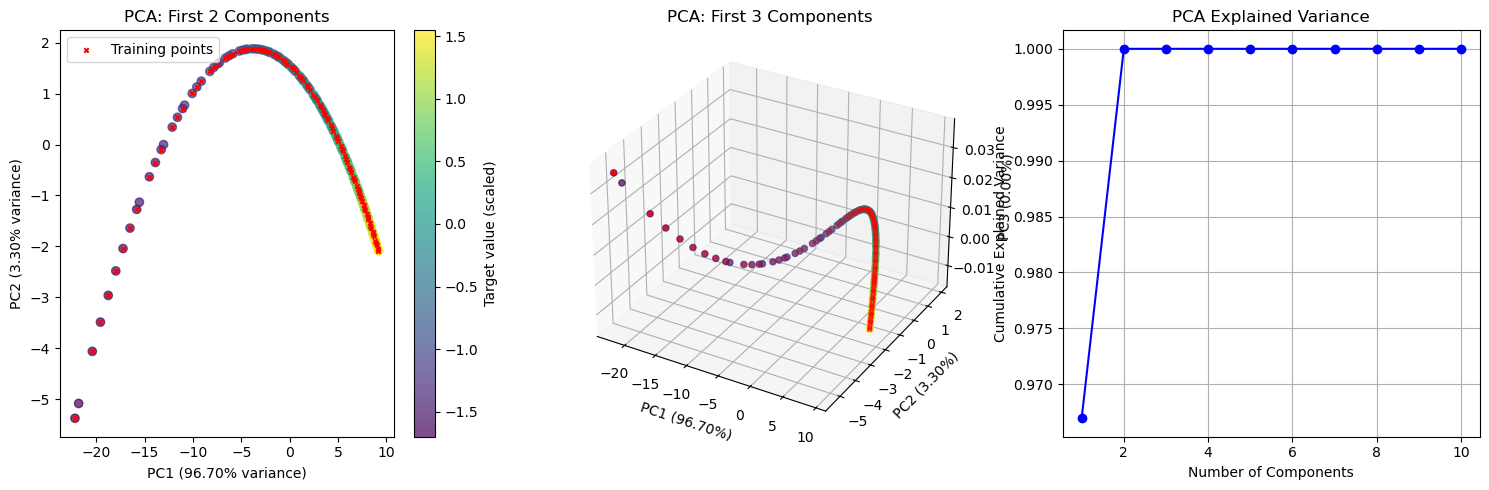

First 2 PCs explain 100.00% of variance
First 3 PCs explain 100.00% of variance


In [7]:
# Visualize PCA results
fig = plt.figure(figsize=(15, 5))

# PCA 2D
ax1 = fig.add_subplot(131)
scatter = ax1.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_scaled, cmap='viridis', alpha=0.7)
scatter = ax1.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test_scaled, cmap='viridis', alpha=0.7)
ax1.scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
           c='red', marker='x', s=10, label='Training points')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax1.set_title('PCA: First 2 Components')
ax1.legend()
plt.colorbar(scatter, ax=ax1, label='Target value (scaled)')

# PCA 3D (first 3 components)
ax2 = fig.add_subplot(132, projection='3d')
scatter = ax2.scatter(X_train_pca_full[:, 0], X_train_pca_full[:, 1], X_train_pca_full[:, 2], c=y_train_scaled, cmap='viridis', alpha=0.7)
scatter = ax2.scatter(X_test_pca_full[:, 0], X_test_pca_full[:, 1], X_test_pca_full[:, 2], c=y_test_scaled, cmap='viridis', alpha=0.7)
ax2.scatter(X_train_pca_full[:, 0], X_train_pca_full[:, 1], X_train_pca_full[:, 2],
           c='red', marker='x', s=10)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')
ax2.set_title('PCA: First 3 Components')

# Explained variance
ax3 = fig.add_subplot(133)
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
ax3.plot(range(1, len(cumsum_var) + 1), cumsum_var, 'bo-')
ax3.set_xlabel('Number of Components')
ax3.set_ylabel('Cumulative Explained Variance')
ax3.set_title('PCA Explained Variance')
ax3.grid(True)

plt.tight_layout()
plt.show()

print(f"First 2 PCs explain {cumsum_var[1]:.2%} of variance")
print(f"First 3 PCs explain {cumsum_var[2]:.2%} of variance")

As we see, the first dimension retrieved in PCA already gives us most of the information from the full-dimensional data. And getting a second dimension already gives us 100% of the information. So we are not losing any accuracy with this step.

Then, we train a Gaussian Process Regressor on this data, using the known scaled Young modulus values as desired output.

In [8]:
# Define kernel for 2D PCA space with better initialization
length_scale_init = np.std(X_train_pca, axis=0)  # Initialize based on data spread
kernel = 1.0 * RBF(length_scale=length_scale_init, length_scale_bounds=(1e-3, 1e3)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e1))

# Fit Gaussian Process
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, 
    n_restarts_optimizer=10,
    alpha=1e-6,  # Small noise term for numerical stability
    normalize_y=True  # Additional normalization
)

# Train on 2D PCA components
gaussian_process.fit(X_train_pca, y_train_scaled)

print("Optimized kernel:", gaussian_process.kernel_)

Optimized kernel: 6.42**2 * RBF(length_scale=[40.4, 10.9]) + WhiteKernel(noise_level=1e-05)


/home/nsibuet/miniconda3/envs/torch/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


We use this trained model to predict the Young modulus values for the test dataset and check the accuracy in terms of relative error.

In [9]:
# Make predictions on train and test sets
y_pred_train_scaled, y_std_train = gaussian_process.predict(X_train_pca, return_std=True)
y_pred_test_scaled, y_std_test = gaussian_process.predict(X_test_pca, return_std=True)

# Calculate performance metrics
train_rel_error = np.linalg.norm(y_train_scaled - y_pred_train_scaled)/np.linalg.norm(y_train_scaled)
test_rel_error = np.linalg.norm(y_test_scaled - y_pred_test_scaled)/np.linalg.norm(y_test_scaled)

print(f"\nModel Performance (on scaled targets):")
print(f"Training relative error: {train_rel_error:.4f}")
print(f"Test relative error: {test_rel_error:.4f}")


Model Performance (on scaled targets):
Training relative error: 0.0005
Test relative error: 0.0005


As expected, the error is very low, meaning that the surrogate model is accurate

Next are some more illustrative plots.

/tmp/ipykernel_1987351/2828324865.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[0, 0].scatter(X_train_pca[:,0], X_train_pca[:,1], c="red",
/tmp/ipykernel_1987351/2828324865.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[0, 0].scatter(X_test_pca[:,0], X_test_pca[:,1], c="orange",


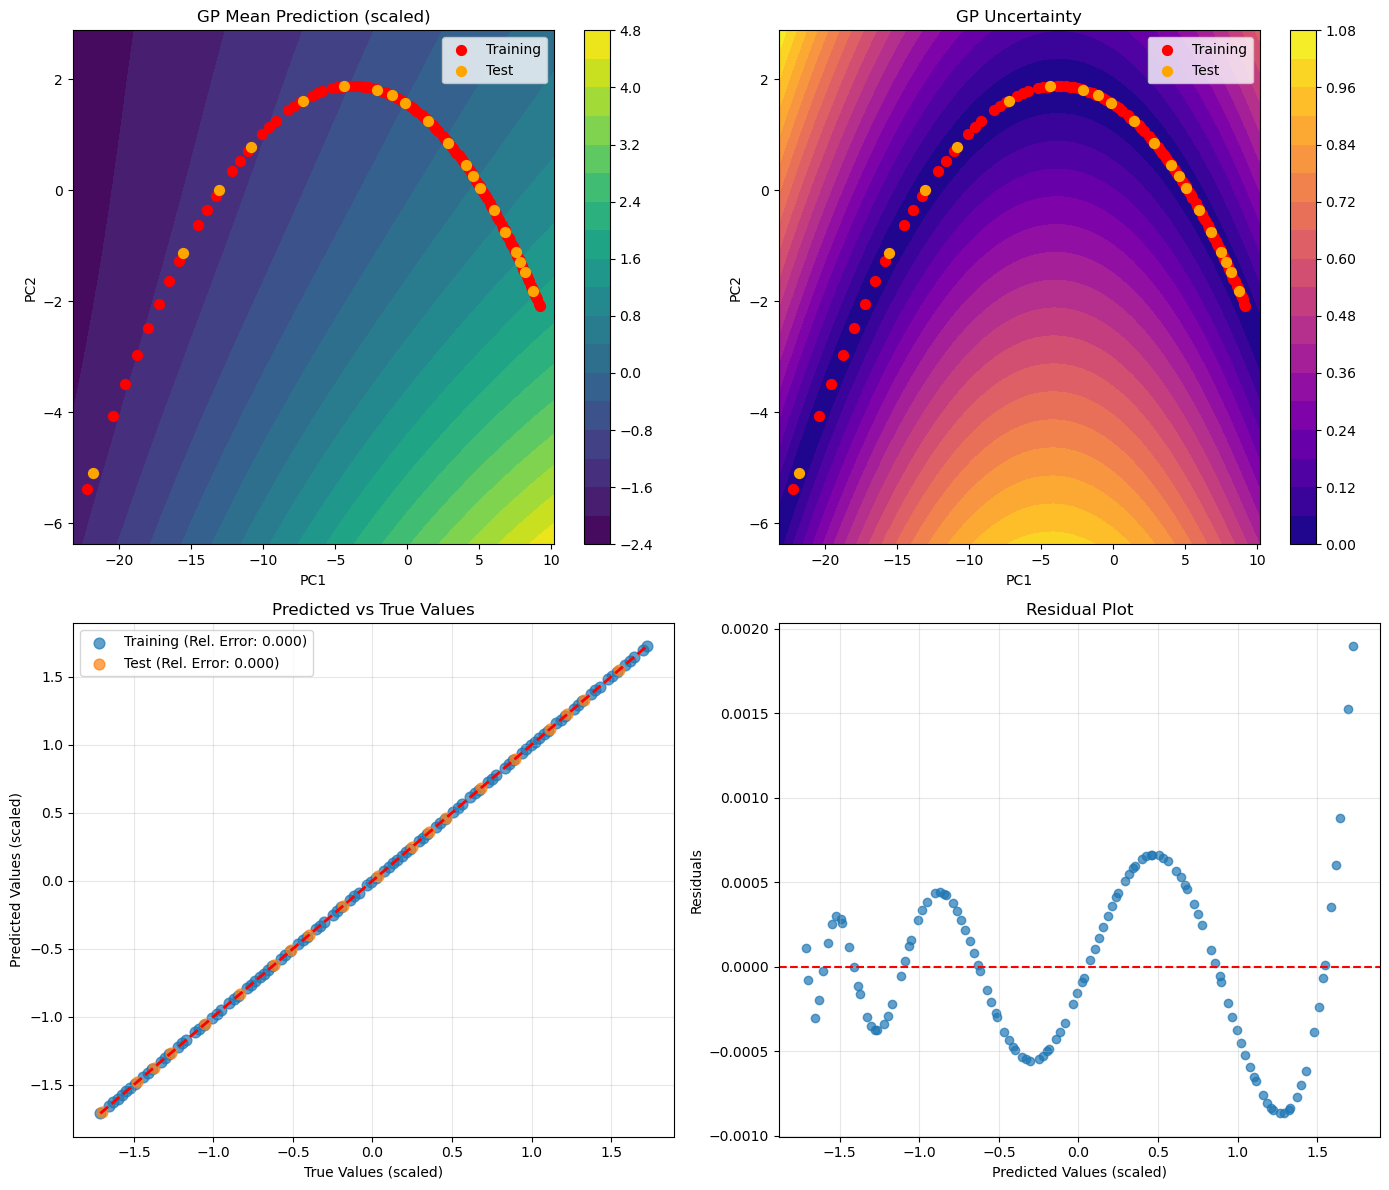


Summary Statistics:
Training set size: 100
Test set size: 20
Mean target value (scaled): -0.0127 ± 0.9990
Mean predicted value (scaled): -0.0127 ± 0.9990
Mean prediction uncertainty: 0.0033
95% confidence interval coverage: 100.00%


In [10]:
# Create a dense grid for visualization
pc1_min, pc1_max = min(X_train_pca[:,0].min(), X_test_pca[:,0].min()) - 1, max(X_train_pca[:,0].max(), X_test_pca[:,0].max()) + 1
pc2_min, pc2_max = min(X_train_pca[:,1].min(), X_test_pca[:,1].min()) - 1, max(X_train_pca[:,1].max(), X_test_pca[:,1].max()) + 1

pc1_grid = np.linspace(pc1_min, pc1_max, 50)
pc2_grid = np.linspace(pc2_min, pc2_max, 50)
PC1_grid, PC2_grid = np.meshgrid(pc1_grid, pc2_grid)

# Flatten for GP prediction
X_grid = np.column_stack([PC1_grid.ravel(), PC2_grid.ravel()])

# Make predictions on the grid
y_grid_pred, y_grid_std = gaussian_process.predict(X_grid, return_std=True)

# Reshape for plotting
Y_grid_pred = y_grid_pred.reshape(PC1_grid.shape)
Y_grid_std = y_grid_std.reshape(PC1_grid.shape)

# 2D contour plots
fig2, axes = plt.subplots(2, 2, figsize=(14, 12))

# GP prediction contour
im1 = axes[0, 0].contourf(PC1_grid, PC2_grid, Y_grid_pred, levels=20, cmap='viridis')
axes[0, 0].scatter(X_train_pca[:,0], X_train_pca[:,1], c="red", 
                             cmap='viridis', s=50, label='Training')
axes[0, 0].scatter(X_test_pca[:,0], X_test_pca[:,1], c="orange", 
                  cmap='viridis', s=50, label='Test')
axes[0, 0].set_title('GP Mean Prediction (scaled)')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
axes[0, 0].legend()
plt.colorbar(im1, ax=axes[0, 0])

# Uncertainty contour
im2 = axes[0, 1].contourf(PC1_grid, PC2_grid, Y_grid_std, levels=20, cmap='plasma')
axes[0, 1].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c='red', s=50, label='Training')
axes[0, 1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c='orange', s=50, label='Test')
axes[0, 1].set_title('GP Uncertainty')
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC2')
axes[0, 1].legend()
plt.colorbar(im2, ax=axes[0, 1])

# Predicted vs True (Training and Test) - using scaled values
axes[1, 0].scatter(y_train_scaled, y_pred_train_scaled, alpha=0.7, label=f'Training (Rel. Error: {train_rel_error:.3f})', s=60)
axes[1, 0].scatter(y_test_scaled, y_pred_test_scaled, alpha=0.7, label=f'Test (Rel. Error: {test_rel_error:.3f})', s=60)
min_val = min(y_train_scaled.min(), y_test_scaled.min(), y_pred_train_scaled.min(), y_pred_test_scaled.min())
max_val = max(y_train_scaled.max(), y_test_scaled.max(), y_pred_train_scaled.max(), y_pred_test_scaled.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[1, 0].set_xlabel('True Values (scaled)')
axes[1, 0].set_ylabel('Predicted Values (scaled)')
axes[1, 0].set_title('Predicted vs True Values')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Residuals
all_y_true = np.concatenate([y_train, y_test])
all_y_true_scaled = np.concatenate([y_train_scaled, y_test_scaled])
all_y_pred_scaled = np.concatenate([y_pred_train_scaled, y_pred_test_scaled])
all_y_std = np.concatenate([y_std_train, y_std_test])
errors = all_y_true_scaled - all_y_pred_scaled

axes[1, 1].scatter(all_y_pred_scaled, errors, alpha=0.7)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Predicted Values (scaled)')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].set_title('Residual Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Training set size: {len(X_train_pca)}")
print(f"Test set size: {len(X_test_pca)}")
# print(f"Mean target value (original): {np.mean(all_y_true):.4e} ± {np.std(all_y_true):.4e}")
print(f"Mean target value (scaled): {np.mean(all_y_true_scaled):.4f} ± {np.std(all_y_true_scaled):.4f}")
print(f"Mean predicted value (scaled): {np.mean(all_y_pred_scaled):.4f} ± {np.std(all_y_pred_scaled):.4f}")
print(f"Mean prediction uncertainty: {np.mean(all_y_std):.4f}")

# Coverage of confidence intervals
abs_errors = np.abs(errors)
coverage_95 = np.mean(abs_errors <= 1.96 * all_y_std)
print(f"95% confidence interval coverage: {coverage_95:.2%}")